In [1]:
import sys 
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle

# import numpy as np 
# import numpy.random as npr 
import shapely
from shapely.plotting import patch_from_polygon, plot_line

sys.path.insert(0, "/Users/njkr/Work/PhD/projects/fibers-standalone/src")
import estimators
import geometry_utils

In [2]:
bounds: np.ndarray = np.array([0., 0., 1., 1.])
num_points: int = 25
points: np.ndarray = np.stack((npr.uniform(bounds[0], bounds[2], size=(num_points,)), npr.uniform(bounds[1], bounds[3], size=(num_points,))), axis=-1)
convex_hull = shapely.convex_hull(shapely.MultiPoint(points))

NameError: name 'np' is not defined

In [3]:
buffer: float = 0.1 
domain_boundary = Rectangle((bounds[0], bounds[1]), width=bounds[2] - bounds[0], height=bounds[3]-bounds[1], fill=False, ec="tab:blue")
hull_patch = patch_from_polygon(convex_hull, fc="lightsteelblue", ec="tab:blue")
chc = np.array(list(convex_hull.exterior.coords))
plt.figure(figsize=(4, 4))
ax = plt.gca() 
ax.add_patch(domain_boundary)
ax.add_patch(hull_patch)
plt.scatter(points[:, 0], points[:, 1], c="k", alpha=0.2)
plt.scatter(chc[:, 0], chc[:, 1], c="tab:red")
plt.xlim(bounds[0] - buffer, bounds[2] + buffer)
plt.ylim(bounds[1] - buffer, bounds[3] + buffer)
plt.show()

NameError: name 'bounds' is not defined

In [52]:
line = shapely.LineString(((0.4, 0.05), (0.5, 0.4)))

In [63]:
clipped_line = np.array(shapely.intersection(line, convex_hull).coords)
intersection = np.linalg.norm(np.array(shapely.intersection(line, convex_hull).coords))
print(f"clipped line: {clipped_line}")
print(f"intersection: {intersection}")

clipped line: [[0.4179197  0.11271894]
 [0.5        0.4       ]]
intersection: 0.7728922531286753


In [64]:
fiber = np.array(line.coords)
convex_hull_points: np.ndarray = np.array(convex_hull.exterior.coords)

clipped_fiber = geometry_utils.clip_inside_convex_hull(fiber[np.newaxis, ...], convex_hull_points)
print(clipped_fiber)
print(np.linalg.norm(clipped_fiber))

[[[0.4179197  0.11271895]
  [0.5        0.4       ]]]
0.7728923


In [4]:
import jax.numpy as np 
import jax.random as npr 

key: np.ndarray = npr.PRNGKey(0)
DTYPE: type = np.float32
DOMAIN_BOUNDS: np.ndarray = np.array([0., 0., 1., 1.])
FIBER_LENGTH: np.ndarray = np.array(2e-01)
NUM_FIBERS: int = 4

def random_convex_polygon(key: np.ndarray, num_points: int = 7) -> tuple[shapely.Polygon, np.ndarray]: 
    xkey, ykey = npr.split(key)
    points: np.ndarray = np.stack(
    (
            npr.uniform(xkey, (num_points,), minval=DOMAIN_BOUNDS[0], maxval=DOMAIN_BOUNDS[2]), 
            npr.uniform(ykey, (num_points,), minval=DOMAIN_BOUNDS[1], maxval=DOMAIN_BOUNDS[3])
    ), axis=-1)
    convex_hull: shapely.Polygon = shapely.convex_hull(shapely.MultiPoint(points))
    convex_hull_points: np.ndarray = np.array(convex_hull.exterior.coords)
    return (convex_hull, convex_hull_points)


def fiber_to_line(fiber: np.ndarray) -> shapely.LineString: 
    return shapely.LineString([fiber[0], fiber[1]])

In [5]:
fiber_key, polygon_key = npr.split(key)
convex_hull, convex_hull_points = random_convex_polygon(polygon_key)
fibers: np.ndarray = estimators.sample(fiber_key, DOMAIN_BOUNDS, NUM_FIBERS, FIBER_LENGTH, dtype=DTYPE)
shapely_fibers: list[shapely.LineString] = [fiber_to_line(f) for f in fibers]

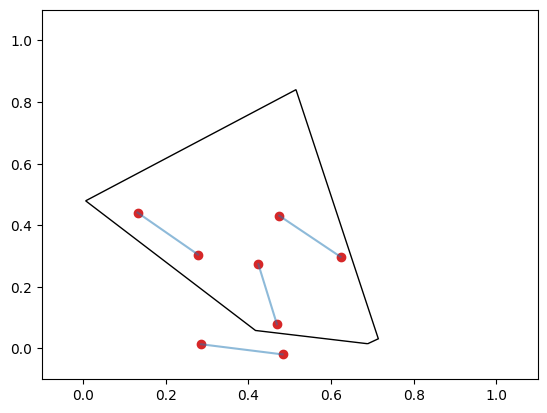

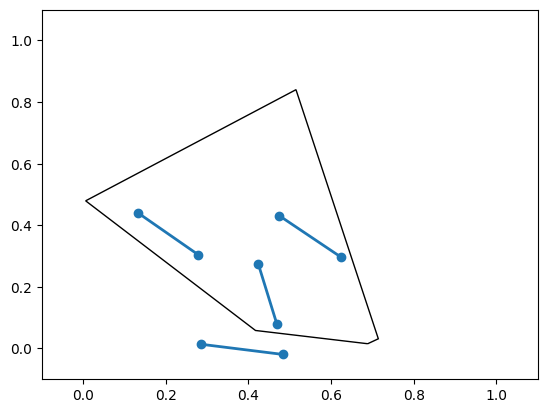

In [6]:
plt.figure() 
for fiber in fibers: 
    plt.scatter(fiber[:, 0], fiber[:, 1], c="tab:red")
    plt.plot(fiber[:, 0], fiber[:, 1], c="tab:blue", alpha=0.5)

ax = plt.gca()
ax.add_patch(patch_from_polygon(convex_hull, fill=False))

plt.xlim(DOMAIN_BOUNDS[0] - buffer, DOMAIN_BOUNDS[2] + buffer)
plt.ylim(DOMAIN_BOUNDS[1] - buffer, DOMAIN_BOUNDS[3] + buffer)
plt.show()

plt.figure() 

ax = plt.gca()
for fiber in shapely_fibers: 
    plot_line(fiber, ax=ax)

ax.add_patch(patch_from_polygon(convex_hull, fill=False))

plt.xlim(DOMAIN_BOUNDS[0] - buffer, DOMAIN_BOUNDS[2] + buffer)
plt.ylim(DOMAIN_BOUNDS[1] - buffer, DOMAIN_BOUNDS[3] + buffer)
plt.show()

In [8]:
clipped_fibers: np.ndarray = geometry_utils.clip_inside_convex_hull(fibers, convex_hull_points[1:])
print(clipped_fibers)

[[[0.2854613  0.01372194]
  [0.2854613  0.01372194]]

 [[0.4690398  0.07869947]
  [0.42412752 0.27359146]]

 [[0.27814484 0.30483854]
  [0.13183397 0.4411952 ]]

 [[0.47454488 0.43120444]
  [0.62317884 0.29738384]]]


In [10]:
estimators.estimate_hull_area(fibers, convex_hull_points[1:])

Array(0.75, dtype=float32)

0.2
0.20000002
0.20000002


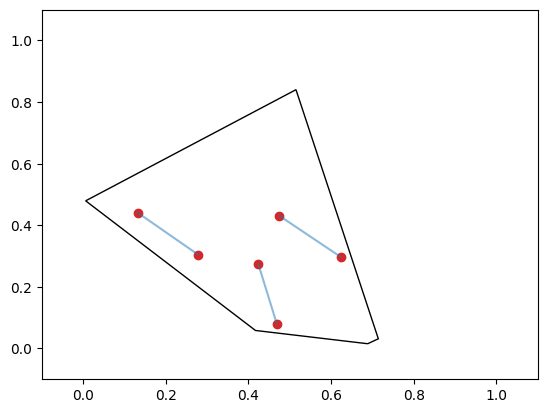

In [11]:
plt.figure() 
for fiber in clipped_fibers: 
    length = np.linalg.norm(fiber[1] - fiber[0])
    if length != 0.: 
        plt.scatter(fiber[:, 0], fiber[:, 1], c="tab:red")
        plt.plot(fiber[:, 0], fiber[:, 1], c="tab:blue", alpha=0.5)

ax = plt.gca()
ax.add_patch(patch_from_polygon(convex_hull, fill=False))

plt.xlim(DOMAIN_BOUNDS[0] - buffer, DOMAIN_BOUNDS[2] + buffer)
plt.ylim(DOMAIN_BOUNDS[1] - buffer, DOMAIN_BOUNDS[3] + buffer)
plt.show()


In [12]:
shapely_clipped_fibers: list[np.ndarray] = [] 
for f in shapely_fibers: 
    intersection_array = np.array(shapely.intersection(f, convex_hull).coords)
    if intersection_array.size > 0: 
        shapely_clipped_fibers.append(intersection_array)

In [15]:
np.array([shapely_clipped_fibers])

Array([[[[0.4690398 , 0.07869947],
         [0.42412752, 0.27359146]],

        [[0.27814484, 0.30483854],
         [0.13183397, 0.4411952 ]],

        [[0.47454488, 0.43120444],
         [0.62317884, 0.29738384]]]], dtype=float32)

In [32]:
didnt_collapse = np.all(clipped_fibers[:, 1] != clipped_fibers[:, 0], axis=-1)
(clipped_fibers[didnt_collapse, ...] == np.array([shapely_clipped_fibers])).all()

Array(True, dtype=bool)

In [29]:
clipped_fibers[

Array([[0.2854613 , 0.01372194],
       [0.2854613 , 0.01372194]], dtype=float32)

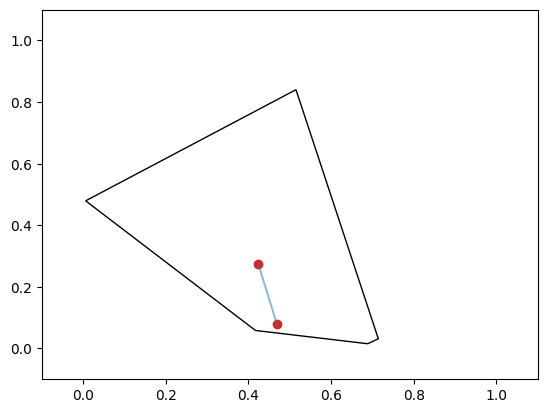

In [13]:
clipped = np.array(shapely.intersection(shapely_fibers[1], convex_hull).coords)

plt.figure() 
plt.scatter(clipped[:, 0], clipped[:, 1], c="tab:red")
plt.plot(clipped[:, 0], clipped[:, 1], c="tab:blue", alpha=0.5)

ax = plt.gca()
ax.add_patch(patch_from_polygon(convex_hull, fill=False))

plt.xlim(DOMAIN_BOUNDS[0] - buffer, DOMAIN_BOUNDS[2] + buffer)
plt.ylim(DOMAIN_BOUNDS[1] - buffer, DOMAIN_BOUNDS[3] + buffer)
plt.show()


In [122]:
fibers[0]

Array([[ 0.2854613 ,  0.01372194],
       [ 0.5813622 , -0.03570146]], dtype=float32)